In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
import glob
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as op
import torchvision.models as mo
from torch.utils.data import DataLoader,Dataset
from PIL import Image
from torchvision import datasets
import matplotlib.pyplot as plt
import tqdm
from sklearn.metrics import accuracy_score,precision_score,recall_score
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
resnet=mo.resnet18(pretrained=True)

In [ ]:
resnet1=mo.resnet18(pretrained=False)

In [ ]:
from torchvision import transforms
transform = transforms.Compose([            #[1]
 transforms.Resize(256),                    #[2]
 transforms.CenterCrop(224),                #[3]
 transforms.ToTensor(),                     #[4]
 transforms.Normalize(                      #[5]
 mean=[0.485, 0.456, 0.406],                #[6]
 std=[0.229, 0.224, 0.225])])


In [ ]:
dirs=glob.glob("../input/cat-and-dog/training_set/training_set/cats/*")
dirs1=glob.glob("../input/cat-and-dog/training_set/training_set/dogs/*")

In [ ]:
imgloader=datasets.ImageFolder("../input/cat-and-dog/training_set/training_set/",transform=transform)

In [ ]:
validimgloader=datasets.ImageFolder("../input/cat-and-dog/test_set/test_set/",transform=transform)

In [ ]:
dataloader = torch.utils.data.DataLoader(imgloader, batch_size=32, shuffle=True)
# images, labels = next(iter(dataloader))


In [ ]:
validdataloader = torch.utils.data.DataLoader(validimgloader, batch_size=32, shuffle=True)

In [ ]:
images, labels = next(iter(dataloader))

In [ ]:
newmodel=nn.Sequential(*(list(resnet.children())[:-1]))

In [ ]:
im=torch.randn((5,3,224,224))

In [ ]:
newmodel(im).shape

In [ ]:
class newmodel(nn.Module):
    def __init__(self,nclasses):
        super().__init__()
        self.cls=nn.Sequential(*(list(resnet.children())[:-1]))
        self.fc=nn.Linear(512,nclasses)
    
    def forward(self,x):
        return self.fc(self.cls(x).squeeze())

In [ ]:
model1=newmodel(2)

In [ ]:
opt=op.Adam(model1.parameters(),lr=0.0001)

In [ ]:
device=torch.device("cuda:0")

In [ ]:
model1=model1.to(device)

In [ ]:
trainloss=[]
validationloss=[]
vaccuracy=[]
c=0
for i in tqdm.tqdm(dataloader):
    opt.zero_grad()
    pred=model1(i[0].to(device))
    loss=f.cross_entropy(pred,i[1].to(device))
    loss.backward()
    opt.step()
    trainloss.append(loss.detach().cpu().item())
    print(loss)
    
    if c%10==0:
        print("---------validation_start-----------")
        model1.eval()
        with torch.no_grad():
            j=0
            validloss=[]
            vpred=[]
            vactual=[]
            for m in validdataloader:
                valpred=model1(m[0].to(device))
                vloss=f.cross_entropy(valpred,m[1].to(device))
                validloss.append(vloss.detach().cpu().item())
                vpred.append(valpred.detach().cpu().argmax(-1).numpy())
                vactual.append(m[1].detach().cpu().numpy())
            validationloss.append(sum(validloss)/len(validloss))
            vaccuracy.append(accuracy_score(np.concatenate(vpred),np.concatenate(vactual)))
            del valpred,vloss,vactual
            torch.cuda.empty_cache()
            print("-----------validation_end--------------")
            print("---loss---- ",validationloss[-1])
            print("---validacc---- ",vaccuracy[-1])
    c+=1
    model1.train()

In [ ]:
plt.plot(trainloss,c="r")
plt.plot(list(range(0,251,10)),validationloss,c='g')

In [ ]:
plt.plot(vaccuracy)

In [ ]:
#model 2 monkey species
imgloader=datasets.ImageFolder("../input/10-monkey-species/training/training/",transform=transform)
validimgloader=datasets.ImageFolder("../input/10-monkey-species/validation/validation/",transform=transform)

In [ ]:
dataloader = torch.utils.data.DataLoader(imgloader, batch_size=32, shuffle=True)
validdataloader = torch.utils.data.DataLoader(validimgloader, batch_size=32, shuffle=True)

In [ ]:
model1.eval()

In [ ]:
model2=newmodel(10)
opt=op.Adam(model2.parameters(),lr=0.0001)
model2=model2.to(device)

In [ ]:
trainloss=[]
validationloss=[]
vaccuracy=[]
c=0
for i in tqdm.tqdm(dataloader):
    opt.zero_grad()
    pred=model2(i[0].to(device))
    loss=f.cross_entropy(pred,i[1].to(device))
    loss.backward()
    opt.step()
    trainloss.append(loss.detach().cpu().item())
    print(loss)
    
    if c%10==0:
        print("---------validation_start-----------")
        model2.eval()
        with torch.no_grad():
            j=0
            validloss=[]
            vpred=[]
            vactual=[]
            for m in validdataloader:
                valpred=model2(m[0].to(device))
                vloss=f.cross_entropy(valpred,m[1].to(device))
                validloss.append(vloss.detach().cpu().item())
                vpred.append(valpred.detach().cpu().argmax(-1).numpy())
                vactual.append(m[1].detach().cpu().numpy())
            validationloss.append(sum(validloss)/len(validloss))
            vaccuracy.append(accuracy_score(np.concatenate(vpred),np.concatenate(vactual)))
            del valpred,vloss,vactual
            torch.cuda.empty_cache()
            print("-----------validation_end--------------")
            print("---loss---- ",validationloss[-1])
            print("---validacc---- ",vaccuracy[-1])
        model2.train()
    c+=1

In [ ]:
plt.plot(trainloss,c="r")
plt.plot(list(range(0,35,10)),validationloss,c='g')

In [ ]:
plt.plot(vaccuracy)

In [ ]:
imgloader=datasets.ImageFolder("../input/cat-and-dog/training_set/training_set/",transform=transform)
validimgloader=datasets.ImageFolder("../input/cat-and-dog/test_set/test_set/",transform=transform)
dataloader = torch.utils.data.DataLoader(imgloader, batch_size=32, shuffle=True)
validdataloader = torch.utils.data.DataLoader(validimgloader, batch_size=32, shuffle=True)

In [ ]:
#model 2 monkey species
imgloader1=datasets.ImageFolder("../input/10-monkey-species/training/training/",transform=transform)
validimgloader1=datasets.ImageFolder("../input/10-monkey-species/validation/validation/",transform=transform)
dataloader1 = torch.utils.data.DataLoader(imgloader1, batch_size=32, shuffle=True)
validdataloader1 = torch.utils.data.DataLoader(validimgloader1, batch_size=32, shuffle=True)

In [ ]:
class distillmodel(nn.Module):
    def __init__(self,dims):
        super().__init__()
        self.cls=nn.Sequential(*(list(resnet1.children())[:-1]))
        self.fc1=nn.Linear(512,dims[0])
        self.fc2=nn.Linear(512,dims[1])
    
    def forward(self,x,c=0):
        out=self.cls(x).squeeze()
        if c==0:
            return self.fc1(out)
        else:
            return self.fc2(out)

In [134]:
model3=distillmodel([2,10])

In [135]:
opt3=op.Adam(model3.parameters(),lr=0.0001)

In [136]:
iter1=iter(dataloader)
iter2=iter(dataloader1)

In [137]:
model3=model3.to(device)

In [138]:
tau=5

In [139]:
def distill_loss(t,p):
    teacherprob=f.softmax(t/tau,dim=1)
    loss=torch.mean(torch.sum(-1*teacherprob*(f.log_softmax(p/tau,dim=1)),1))
    return loss

In [140]:
model2.eval()

newmodel(
  (cls): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [141]:
for t in model1.parameters():
    t.requires_grad=False

In [142]:
for t in model2.parameters():
    t.requires_grad=False

In [143]:
iter1=iter(dataloader)
iter2=iter(dataloader1)

In [144]:
trainloss1=[]
trainloss2=[]
validationloss=[]
vaccuracy=[]
c=0
while True:
    try:
        i=next(iter1)
    except:
        iter1=iter(dataloader)
        i=next(iter1)
    try:
        j=next(iter2)
        
    except:
        iter2=iter(dataloader1)
        c+=1
        print(c)
        j=next(iter2)
        if c==300:
            break
    opt3.zero_grad()
    
    #first 2 classes
    pred=model3(i[0].to(device),c=0)
    teacher=model1(i[0].to(device)).detach()
    loss1=distill_loss(teacher,pred)
    
    # first 10 classes
    pred1=model3(j[0].to(device),c=1)
    teacher1=model2(j[0].to(device)).detach()
    loss2=distill_loss(teacher1,pred1)
    
    tloss=(loss1+loss2)/2
    tloss.backward()
    opt3.step()
    trainloss1.append(loss1.detach().cpu().item())
    trainloss2.append(loss2.detach().cpu().item()) 

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


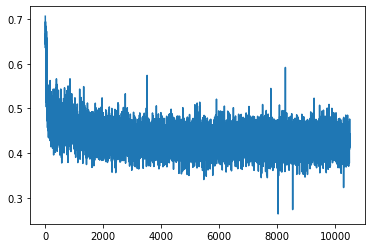

In [145]:
plt.plot(trainloss1)

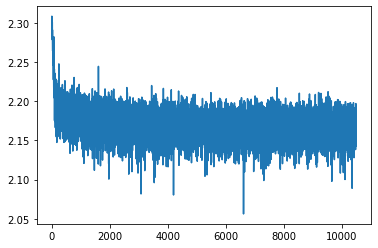

In [146]:
plt.plot(trainloss2)

In [147]:
model3.eval()
with torch.no_grad():
    j=0
    validloss=[]
    vpred=[]
    vactual=[]
    for m in validdataloader:
        valpred=model3(m[0].to(device),0)
        vloss=f.cross_entropy(valpred,m[1].to(device))
        validloss.append(vloss.detach().cpu().item())
        vpred.append(valpred.detach().cpu().argmax(-1).numpy())
        vactual.append(m[1].detach().cpu().numpy())
#     validationloss.append(sum(validloss)/len(validloss))
#     vaccuracy.append(accuracy_score(np.concatenate(vpred),np.concatenate(vactual)))
#     del valpred,vloss,vactual
#     torch.cuda.empty_cache()
#     print("-----------validation_end--------------")
#     print("---loss---- ",validationloss[-1])
#     print("---validacc---- ",vaccuracy[-1])

In [148]:
accuracy_score(np.concatenate(vpred),np.concatenate(vactual))

0.8171033119130005

In [149]:
model3.eval()
with torch.no_grad():
    j=0
    validloss=[]
    vpred=[]
    vactual=[]
    for m in validdataloader1:
        valpred=model3(m[0].to(device),1)
        vloss=f.cross_entropy(valpred,m[1].to(device))
        validloss.append(vloss.detach().cpu().item())
        vpred.append(valpred.detach().cpu().argmax(-1).numpy())
        vactual.append(m[1].detach().cpu().numpy())
        


In [150]:
accuracy_score(np.concatenate(vpred),np.concatenate(vactual))

0.7426470588235294